In [ ]:
'''
Goals for this:

For the farms that we are visiting, get analytics on:
- Number of delicings
- Average time between delicings
- Average growth cycle

'''

In [162]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [10]:
df = pd.read_csv('/root/bryton/github/cv_research/bryton/ml_sealice/combined_2016_2018.csv')

total_start_date = (2016, 1)
total_end_date = (2018, 45)

In [221]:
def generate_cohorts(localityNo):
    
    subset = df.loc[df['localityNo'] == localityNo]

    np_subset = subset.values

    cohorts = []

    last_date = None
    start_date = None

    num_mechanical = 0
    num_bath = 0
    num_in_feed = 0
    num_cleaner_fish = 0

    lice_levels = []
    last_lice_level = None

    all_af_lice_levels = []
    af_lice_levels = []
    
    num_dates = np_subset.shape[0]

    for i in range(num_dates):
        year = np_subset[i,2]
        week = np_subset[i,3]
        hasMechanicalRemoval = np_subset[i,5]
        hasBathTreatment = np_subset[i,6]
        hasInFeedTreatment = np_subset[i,7]
        hasCleanerFishDeployed = np_subset[i,8]
        avgAdultFemaleLice = np_subset[i,10]
        avgMobileLice = np_subset[i,11]
        avgStationaryLice = np_subset[i,12]

        lice_level = (avgStationaryLice, avgMobileLice, avgAdultFemaleLice)

        date = (year, week)
        #print(date)

        if last_date and (last_date[0] == year and (week - last_date[1]) <= 2 or (last_date[0] == (year - 1) and week == 1)): 
            if hasMechanicalRemoval:
                num_mechanical = num_mechanical + 1

                lice_levels.append((last_lice_level, lice_level))
            if hasBathTreatment:
                num_bath = num_bath + 1
            if hasInFeedTreatment:
                num_in_feed = num_in_feed + 1
            if hasCleanerFishDeployed:
                num_cleaner_fish = num_cleaner_fish + 1
        else:
            if start_date is not None:
                is_complete = not (start_date[0] == total_start_date[0] and start_date[1] == total_start_date[1])
                
                cohorts.append({
                    'start_date': start_date,
                    'end_date': last_date, 
                    'is_complete': is_complete, 
                    'num_mechanical': num_mechanical,
                    'num_bath': num_bath,
                    'num_in_feed': num_in_feed,
                    'num_cleaner_fish': num_cleaner_fish,
                    'lice_levels': lice_levels,
                    'all_af_lice_levels': all_af_lice_levels
                })

            start_date = date

            num_mechanical = 0
            num_bath = 0
            num_in_feed = 0
            num_cleaner_fish = 0

            lice_levels = []
            all_af_lice_levels = []

        last_date = date
        last_lice_level = lice_level
        
        if hasMechanicalRemoval:
            all_af_lice_levels.append(af_lice_levels)
            
            af_lice_levels = []
            
        af_lice_levels.append(lice_level[2])

    is_complete = !(date[0] == total_end_date[0] and date[1] == total_end_date[1])

    if start_date and end_date:
        cohorts.append({
            'start_date': start_date,
            'end_date': last_date, 
            'is_complete': False, 
            'num_mechanical': num_mechanical,
            'num_bath': num_bath,
            'num_in_feed': num_in_feed,
            'num_cleaner_fish': num_cleaner_fish,
            'lice_levels': lice_levels,
            'all_af_lice_levels': all_af_lice_levels
        })    
    
    return cohorts

In [222]:
def generate_report(site_name, cohorts, show_detail, show_cohort_detail):
    if show_detail:
        print('Report for %s: (%i, %i) -> (%i, %i)' % (site_name, total_start_date[0], total_start_date[1], total_end_date[0], total_end_date[1]))

    total_months = 0
    total_delicings = 0
    all_af_lice_levels = []
    
    for index, cohort in enumerate(cohorts):
        start_date = cohort['start_date']
        end_date = cohort['end_date']
        is_complete = cohort['is_complete']
        num_mechanical = cohort['num_mechanical']
        num_bath = cohort['num_bath']
        num_in_feed = cohort['num_in_feed']
        num_cleaner_fish = cohort['num_cleaner_fish']
        lice_levels = cohort['lice_levels']
        af_lice_levels = cohort['all_af_lice_levels']

        avg_lice_level_before = [0, 0, 0]
        avg_lice_level_after = [0, 0, 0]
        avg_lice_level_delta = [0, 0, 0]

        for lice_level in lice_levels:
            for i in range(3):
                avg_lice_level_before[i] = avg_lice_level_before[i] + lice_level[0][i] / len(lice_levels)
                avg_lice_level_after[i] = avg_lice_level_after[i] + lice_level[1][i] / len(lice_levels)

        for i in range(3):
            avg_lice_level_delta[i] = avg_lice_level_before[i] - avg_lice_level_after[i]

        avg_lice_level_before = (avg_lice_level_before[0], avg_lice_level_before[1], avg_lice_level_before[2])
        avg_lice_level_after = (avg_lice_level_after[0], avg_lice_level_after[1], avg_lice_level_after[2])
        avg_lice_level_delta = (avg_lice_level_delta[0], avg_lice_level_delta[1], avg_lice_level_delta[2])

        cohort_length = end_date[0] * 52 + end_date[1] - (start_date[0] * 52 + start_date[1])
        cohort_length_months = cohort_length / 52.0 * 12.0
        
        total_months = total_months + cohort_length_months
        total_delicings = total_delicings + num_mechanical
        all_af_lice_levels = all_af_lice_levels + af_lice_levels

        if is_complete:
            complete_status = 'complete'
        else:
            complete_status = 'incomplete'

        if show_cohort_detail:
            print()

            print('Cohort %i: (%i, %i) -> (%i, %i), %0.1f months, %s' % (index + 1, start_date[0], start_date[1], end_date[0], end_date[1], cohort_length_months, complete_status))

            print()

            print('Num delicings: %i (every %0.1f months)' % (num_mechanical, cohort_length_months / num_mechanical if num_mechanical > 0 else 0))
            print('Num bath: %i (every %0.1f months)' % (num_bath, cohort_length_months / num_bath if num_bath > 0 else 0))
            print('Num in feed: %i (every %0.1f months)' % (num_in_feed, cohort_length_months / num_in_feed if num_in_feed > 0 else 0))
            print('Num cleaner fish: %i (every %0.1f months)' % (num_cleaner_fish, cohort_length_months / num_cleaner_fish if num_cleaner_fish > 0 else 0))

            print('Avg lice level before: (%0.2f, %0.2f, %0.2f)' % avg_lice_level_before)
            print('Avg lice level after: (%0.2f, %0.2f, %0.2f)' % avg_lice_level_after)
            print('Avg lice level delta: (%0.2f, %0.2f, %0.2f)' % avg_lice_level_delta)
       
    if show_detail:
        print()
        print('Overall num delicings: %i (%0.1f / yr, every %0.1f months)' % (total_delicings, total_delicings / total_months * 12 if total_months > 0 else 0, total_months / total_delicings if total_delicings > 0 else 0))
        print()
    
    return (total_delicings, total_months, all_af_lice_levels)

In [223]:
site_name = 'Kjeppevikholmen'

localityNo = 11652 # Kjeppevikholmen

cohorts = generate_cohorts(localityNo)

generate_report(site_name, cohorts, True, True)

Report for Kjeppevikholmen: (2016, 1) -> (2018, 45)

Cohort 1: (2016, 11) -> (2017, 28), 15.9 months, complete

Num delicings: 5 (every 3.2 months)
Num bath: 1 (every 15.9 months)
Num in feed: 8 (every 2.0 months)
Num cleaner fish: 0 (every 0.0 months)
Avg lice level before: (1.31, 3.48, 0.45)
Avg lice level after: (0.31, 0.30, 0.08)
Avg lice level delta: (1.00, 3.17, 0.37)

Cohort 2: (2018, 12) -> (2018, 45), 7.6 months, incomplete

Num delicings: 2 (every 3.8 months)
Num bath: 0 (every 0.0 months)
Num in feed: 0 (every 0.0 months)
Num cleaner fish: 1 (every 7.6 months)
Avg lice level before: (0.04, 3.73, 0.45)
Avg lice level after: (0.01, 0.16, 0.10)
Avg lice level delta: (0.02, 3.57, 0.34)

Overall num delicings: 7 (3.6 / yr, every 3.4 months)



(7,
 23.53846153846154,
 [[0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.08,
   0.06,
   0.07,
   0.12,
   0.08,
   0.07,
   0.1,
   0.07,
   0.07,
   0.1,
   0.17,
   0.1,
   0.23,
   0.1,
   0.36,
   0.27,
   0.23,
   0.2,
   0.28,
   0.33,
   0.27,
   0.3,
   0.37,
   0.33,
   0.37,
   0.37,
   0.43,
   0.47],
  [0.1, 0.23, 0.36, 0.4, 0.47],
  [0.0, 0.1, 0.23, 0.47, 0.63],
  [0.13, 0.27, 0.37, 0.4, 0.48, 0.55],
  [0.1, 0.1, 0.13, 0.05, 0.15],
  [0.07,
   0.1,
   0.27,
   0.3,
   0.4,
   0.4,
   0.3,
   0.2,
   0.3,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.1,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.03,
   0.0,
   0.0,
   0.07,
   0.13,
   0.17,
   0.03,
   0.23,
   0.3,
   0.37,
   0.43],
  [0.18, 0.1, 0.37, 0.25, 0.43, 0.47]])

Report for Allersholmen: (2016, 1) -> (2018, 45)

Cohort 1: (2016, 1) -> (2016, 21), 4.6 months, incomplete

Num delicings: 3 (every 1.5 months)
Num bath: 0 (every 0.0 months)
Num in feed: 0 (every 0.0 months)
Num cleaner fish: 0 (every 0.0 months)
Avg lice level before: (0.45, 1.52, 0.35)
Avg lice level after: (0.13, 0.15, 0.12)
Avg lice level delta: (0.32, 1.37, 0.23)

Cohort 2: (2018, 32) -> (2018, 45), 3.0 months, incomplete

Num delicings: 0 (every 0.0 months)
Num bath: 0 (every 0.0 months)
Num in feed: 0 (every 0.0 months)
Num cleaner fish: 1 (every 3.0 months)
Avg lice level before: (0.00, 0.00, 0.00)
Avg lice level after: (0.00, 0.00, 0.00)
Avg lice level delta: (0.00, 0.00, 0.00)

Overall num delicings: 3 (4.7 / yr, every 2.5 months)

Report for Bøøy: (2016, 1) -> (2018, 45)

Cohort 1: (2016, 34) -> (2017, 39), 13.2 months, complete

Num delicings: 1 (every 13.2 months)
Num bath: 1 (every 13.2 months)
Num in feed: 6 (every 2.2 months)
Num cleaner fish: 2 (every 6.6 months)
Avg

Report for Vikane: (2016, 1) -> (2018, 45)

Cohort 1: (2016, 1) -> (2017, 15), 15.2 months, incomplete

Num delicings: 10 (every 1.5 months)
Num bath: 0 (every 0.0 months)
Num in feed: 3 (every 5.1 months)
Num cleaner fish: 0 (every 0.0 months)
Avg lice level before: (1.54, 2.41, 0.38)
Avg lice level after: (0.14, 0.17, 0.07)
Avg lice level delta: (1.40, 2.23, 0.31)

Cohort 2: (2017, 35) -> (2018, 45), 14.3 months, incomplete

Num delicings: 6 (every 2.4 months)
Num bath: 0 (every 0.0 months)
Num in feed: 3 (every 4.8 months)
Num cleaner fish: 1 (every 14.3 months)
Avg lice level before: (1.00, 3.37, 0.76)
Avg lice level after: (0.33, 0.29, 0.14)
Avg lice level delta: (0.66, 3.08, 0.62)

Overall num delicings: 16 (6.5 / yr, every 1.8 months)

14.076923076923075
Overall num delicings: 101 (5.1 / yr, every 2.3 months)

Key: weekly increase, start level, end level, num_weeks
0: -1.000, 0.000, 0.100, 0.46, 0.020
5: -0.750, 0.000, 0.345, 0.92, 0.050
10: -0.412, 0.000, 0.370, 1.15, 0.070
15:

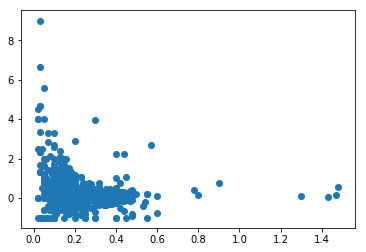

In [257]:
blom_sites = [
    ('Allersholmen', 11756),
    ('Bøøy', 11754),
    ('Gardskråneset', 11667),
    ('Kjeppevikholmen', 11652),
    ('Laksevika', 10080),
    ('Ljøsøy N', 14435),
    ('Nesbø Gjeldsvik', 13965),
    ('Otterholmen', 11738),
    ('Rekeviki', 10086),
    ('Rorsundet N', 19517),
    ('Syrtangen', 10309),
    ('Vikane', 13704)
]

total_cohorts = 0
total_delicings = 0
total_months = 0
total_months_complete = 0
all_af_lice_levels = []

for site in blom_sites:
    site_name = site[0]
    localityNo = site[1]
    
    cohorts = generate_cohorts(localityNo)

    site_total_delicings, site_total_months, site_af_lice_levels = generate_report(site_name, cohorts, True, True)
    
    for cohort in cohorts:
        if cohort['is_complete']:
            start_date = cohort['start_date']
            end_date = cohort['end_date']
            
            cohort_length = end_date[0] * 52 + end_date[1] - (start_date[0] * 52 + start_date[1])
            cohort_length_months = cohort_length / 52.0 * 12.0
        
            total_cohorts = total_cohorts + 1
            total_months_complete = total_months_complete + cohort_length_months
            
    total_delicings = total_delicings + site_total_delicings
    total_months = total_months + site_total_months
    all_af_lice_levels = all_af_lice_levels + site_af_lice_levels
    
#print(all_af_lice_levels)
    
print(total_months_complete / total_cohorts)
    
print('Overall num delicings: %i (%0.1f / yr, every %0.1f months)' % (total_delicings, total_delicings / total_months * 12, total_months / total_delicings if total_delicings > 0 else 0))

print()
longest_level = 0

for af_lice_levels in all_af_lice_levels:
    af_lice_levels_length = len(af_lice_levels)
    if af_lice_levels_length > longest_level:
        longest_level = af_lice_levels_length

#print(longest_level)

#plot_levels = []

avg_start = []
avg_end = []
avg_increases = []
avg_increase_level = []
avg_num_weeks = []

for af_lice_levels in all_af_lice_levels:
    for i in range(len(af_lice_levels) - 1):
        avg_start.append(af_lice_levels[0])
        avg_end.append(af_lice_levels[len(af_lice_levels) - 1])
        avg_num_weeks.append(len(af_lice_levels))
        
        if af_lice_levels[i] > 0:
            increase = (af_lice_levels[i + 1] - af_lice_levels[i]) / af_lice_levels[i]
            avg_increases.append(increase)
            avg_increase_level.append(af_lice_levels[i])
    #np_af_lice_levels = np.array(af_lice_levels)
    #print(np_af_lice_levels)
    #af_lice_levels_length = len(af_lice_levels)
    #plot_level = np.concatenate((np.array(af_lice_levels), np.repeat(0, longest_level - af_lice_levels_length)))
    #plot_levels.append(plot_level)

#np_avg_increases = np.array(avg_increases)
    
#print(np.median(avg_start))
#print(np.median(avg_end))

#print(np.median(np_avg_increases))
#print(np.mean(avg_num_weeks))

print('Key: weekly increase, start level, end level, num_weeks')

for i in range(0, 100, 5):
    p1 = np.percentile(avg_increases, i)
    p2 = np.percentile(avg_start, i)
    p3 = np.percentile(avg_end, i)
    p4 = np.percentile(avg_num_weeks, i)
    p5 = np.percentile(avg_increase_level, i)
    
    print('%i: %0.3f, %0.3f, %0.3f, %0.2f, %0.3f' % (i, p1, p2, p3, p4 / 52.0 * 12, p5))
    
#np_plot_levels = np.array(plot_levels)

#print(np_plot_levels.shape)

#plt.plot(np_plot_levels.T[:, 14])
#plt.show()

print(total_delicings)

print('Average time between delicings is %0.2f months, on average expect delicing every %0.2f months' % (np.mean(avg_num_weeks) / 52.0 * 12, total_months / total_delicings))

plt.scatter(avg_increase_level, avg_increases)
plt.show()



6.6923076923076925